In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

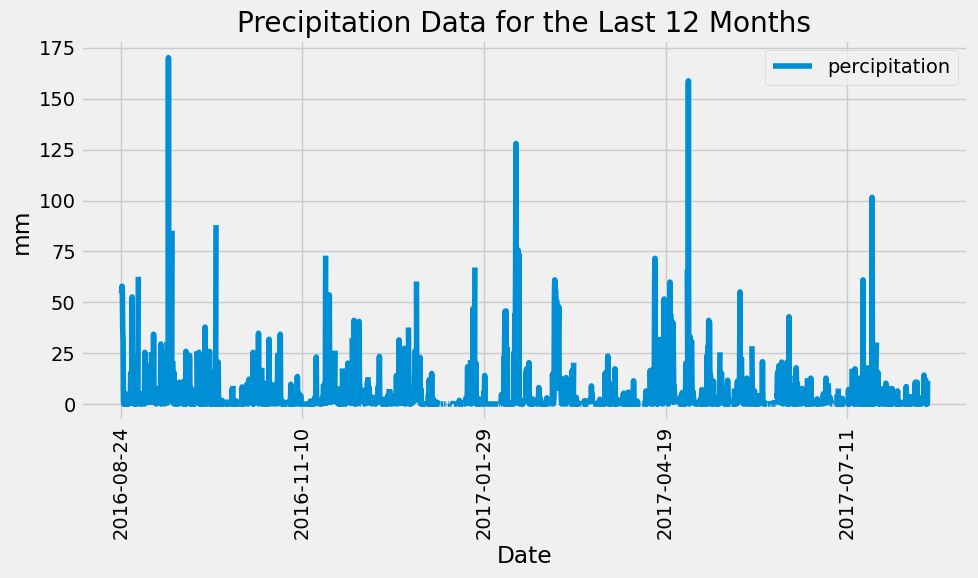

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date_str = most_recent_date[0]
recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
date_one_year_ago = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_and_percp_data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= date_one_year_ago).\
                            filter(Measurement.date <= recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_and_percp_data_df = pd.DataFrame(date_and_percp_data, columns=['date','percipitation'])
#date_and_percp_data_df = date_and_percp_data_df.dropna(how='any')

# Sort the dataframe by date
date_and_percp_data_df = date_and_percp_data_df.sort_values(by='date')
date_and_percp_data_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
date_and_percp_data_df.plot(figsize=(10, 6))
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('mm')
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = date_and_percp_data_df['percipitation'].describe()
pd.DataFrame(summary)

,percipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(Measurement.station).distinct().count()
total_station

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_station[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)
                                 ).filter(Measurement.station == most_active_station_id).all()
temperature_stats

[(12.2, 29.4, 22.03582251082252)]

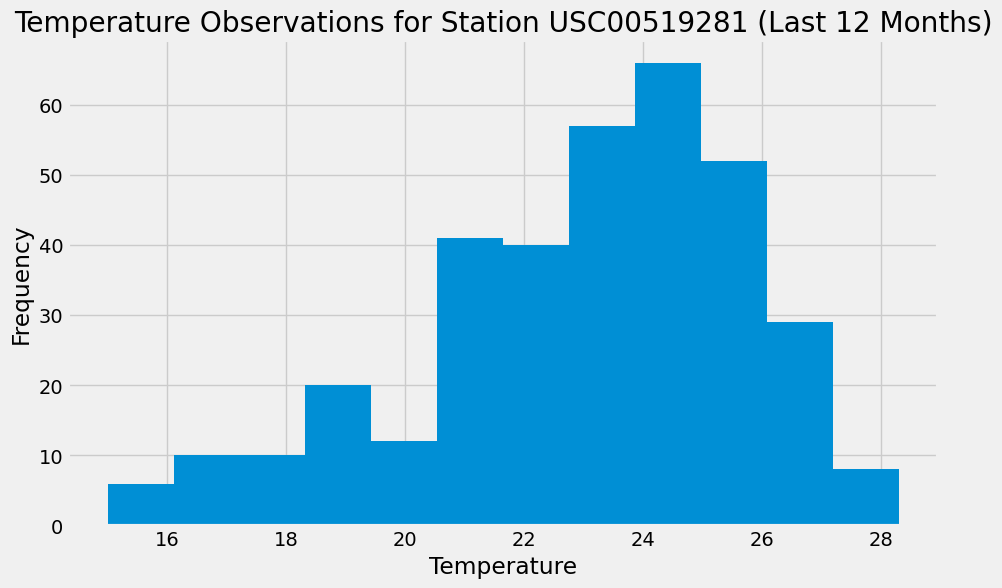

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= date_one_year_ago).all()

# Extract the temperatures from the query result
temperatures = [temp[0] for temp in temperature_data]

#Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12)
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [24]:
# Close Session
session.close()
